In [1]:
# !pip install torch torchvision numpy pillow wandb

In [2]:
#Delete everything in the kaggle workign directory
import shutil
import os

working_dir = '/kaggle/working/'

# Remove all files and folders inside the working directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # remove file or link
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # remove directory
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

print("All contents in /kaggle/working/ have been deleted.")

All contents in /kaggle/working/ have been deleted.


In [6]:
#wandb integration
# !pip install wandb
import wandb
wandb.login(key='4223dffed4a3cb349669a18817f8b2aa2971acc5')

print("✅ Wandb login successful!")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: suhastg1282004 (suhastg1282004-na) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Wandb login successful!


In [7]:
import os, json, random
from glob import glob
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Configuration
ROOT_DIR = '/kaggle/input/dataset/dataset'
IMG_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 50  # Reduced for faster training
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('🚀 Using device:', DEVICE)

# Color mapping
COLOR_MAP = {
    'red': [255, 0, 0],
    'green': [0, 255, 0], 
    'blue': [0, 0, 255],
    'yellow': [255, 255, 0],
    'purple': [128, 0, 128],
    'orange': [255, 165, 0],
    'pink': [255, 192, 203],
    'cyan': [0, 255, 255],
    'brown': [165, 42, 42],
    'black': [0, 0, 0]
}

🚀 Using device: cuda


In [8]:
class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, split='training'):
        base = os.path.join(root_dir, split)
        entries = json.load(open(os.path.join(base, 'data.json')))
        self.samples = []
        
        for e in entries:
            inp_path = os.path.join(base, 'inputs', e['input_polygon'])
            out_path = os.path.join(base, 'outputs', e['output_image'])
            color = e['colour'].lower()
            self.samples.append((inp_path, out_path, color))
            
        # Get all unique colors for encoding
        all_colors = list(set([s[2] for s in self.samples]))
        self.color_encoder = {color: i for i, color in enumerate(all_colors)}
        self.num_colors = len(all_colors)
        
        self.tf_img = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        inp_path, out_path, color = self.samples[i]
        
        # Load input image (polygon outline)
        img = Image.open(inp_path).convert('RGB')
        x = self.tf_img(img)
        
        # Load target image and create proper mask
        tgt_img = Image.open(out_path).convert('RGB')
        tgt_tensor = self.tf_img(tgt_img)
        
        # Create mask: areas that are NOT white (filled regions)
        tgt_gray = transforms.Grayscale()(tgt_tensor)
        mask = (tgt_gray < 0.95).float()  # Non-white pixels
        
        # Encode color
        color_idx = self.color_encoder[color]
        
        # Get RGB values for the color
        if color in COLOR_MAP:
            color_rgb = torch.tensor(COLOR_MAP[color], dtype=torch.float32) / 255.0
        else:
            # Extract color from target image
            tgt_np = np.array(tgt_img)
            filled_pixels = tgt_np[tgt_np.mean(axis=2) < 240]  # Non-white pixels
            if len(filled_pixels) > 0:
                color_rgb = torch.tensor(filled_pixels.mean(axis=0), dtype=torch.float32) / 255.0
            else:
                color_rgb = torch.tensor([1.0, 0.0, 0.0])  # Default to red
        
        return x, mask, color_idx, color_rgb

# Test dataset loading
print("📂 Testing dataset loading...")
try:
    ds_test = PolygonColorDataset(ROOT_DIR, 'training')
    print(f"✅ Training samples: {len(ds_test)}")
    print(f"✅ Number of colors: {ds_test.num_colors}")
    print(f"✅ Colors: {list(ds_test.color_encoder.keys())}")
except Exception as e:
    print(f"❌ Dataset loading error: {e}")

📂 Testing dataset loading...
✅ Training samples: 56
✅ Number of colors: 8
✅ Colors: ['magenta', 'yellow', 'red', 'blue', 'green', 'purple', 'orange', 'cyan']


In [9]:
class ColorConditionedUNet(nn.Module):
    def __init__(self, num_colors, chans=[64, 128, 256, 512]):
        super().__init__()
        
        # Color embedding
        self.color_embedding = nn.Embedding(num_colors, 64)
        self.color_proj = nn.Linear(64, IMG_SIZE * IMG_SIZE)
        
        # Encoder
        self.encoders = nn.ModuleList()
        # First encoder takes 4 channels: 3 (RGB) + 1 (color map)
        in_ch = 4 
        for i, c in enumerate(chans):
            self.encoders.append(nn.Sequential(
                nn.Conv2d(in_ch, c, 3, padding=1), 
                nn.BatchNorm2d(c),
                nn.ReLU(inplace=True),
                nn.Conv2d(c, c, 3, padding=1),     
                nn.BatchNorm2d(c),
                nn.ReLU(inplace=True)
            ))
            in_ch = c
            
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(chans[-1], chans[-1]*2, 3, padding=1), 
            nn.BatchNorm2d(chans[-1]*2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(chans[-1]*2, chans[-1]*2, 3, padding=1), 
            nn.BatchNorm2d(chans[-1]*2),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        rev = chans[::-1]
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(c*2, c, 2, stride=2) for c in rev
        ])
        self.decoders = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(c*2, c, 3, padding=1), 
                nn.BatchNorm2d(c),
                nn.ReLU(inplace=True),
                nn.Conv2d(c, c, 3, padding=1),   
                nn.BatchNorm2d(c),
                nn.ReLU(inplace=True)
            ) for c in rev
        ])
        
        self.final = nn.Conv2d(chans[0], 1, 1)

    def forward(self, x, color_idx):
        batch_size = x.size(0)
        
        # Generate color conditioning map
        color_emb = self.color_embedding(color_idx)  # [B, 64]
        color_map = self.color_proj(color_emb)       # [B, H*W]
        color_map = color_map.view(batch_size, 1, IMG_SIZE, IMG_SIZE)  # [B, 1, H, W]
        
        # Concatenate input image with color map
        x = torch.cat([x, color_map], dim=1)  # [B, 4, H, W]
        
        # Encoder path
        skips = []
        for enc in self.encoders:
            x = enc(x)
            skips.append(x)
            x = self.pool(x)
            
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder path
        for upc, dec, skip in zip(self.upconvs, self.decoders, reversed(skips)):
            x = upc(x)
            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([skip, x], dim=1)
            x = dec(x)
            
        return self.final(x)

# Test model creation
print("🧠 Testing model creation...")
try:
    test_model = ColorConditionedUNet(num_colors=10)
    total_params = sum(p.numel() for p in test_model.parameters())
    print(f"✅ Model created successfully!")
    print(f"✅ Total parameters: {total_params:,}")
except Exception as e:
    print(f"❌ Model creation error: {e}")

🧠 Testing model creation...
✅ Model created successfully!
✅ Total parameters: 32,109,697


In [10]:
def log_sample_predictions(model, dataset, color_encoder, epoch, num_samples=6):
    """Log sample predictions to wandb"""
    model.eval()
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    images_to_log = []
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            x, gt_mask, color_idx, color_rgb = dataset[idx]
            x_batch = x.unsqueeze(0).to(DEVICE)
            color_idx_batch = torch.tensor([color_idx]).to(DEVICE)
            
            logits = model(x_batch, color_idx_batch)[0, 0].cpu()
            pred_mask = (torch.sigmoid(logits) > 0.5).numpy()
            
            fig, axes = plt.subplots(1, 4, figsize=(12, 3))
            
            input_img = x.permute(1, 2, 0).numpy()
            axes[0].imshow(input_img)
            axes[0].set_title('Input')
            axes[0].axis('off')
            
            axes[1].imshow(gt_mask[0].numpy(), cmap='gray')
            axes[1].set_title('GT Mask')
            axes[1].axis('off')
            
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title('Pred Mask')
            axes[2].axis('off')
            
            color_name = list(color_encoder.keys())[list(color_encoder.values()).index(color_idx)]
            fill_color = COLOR_MAP.get(color_name, [255, 0, 0])
            
            input_np = (input_img * 255).astype(np.uint8)
            filled_img = input_np.copy()
            filled_img[pred_mask] = fill_color
            
            axes[3].imshow(filled_img)
            axes[3].set_title(f'Filled ({color_name})')
            axes[3].axis('off')
            
            plt.tight_layout()
            
            wandb_image = wandb.Image(fig, caption=f"Sample {i+1}: {color_name} - Epoch {epoch}")
            images_to_log.append(wandb_image)
            plt.close(fig)
    
    wandb.log({f"predictions/epoch_{epoch}": images_to_log}, step=epoch)
    print(f"📸 Logged {len(images_to_log)} prediction samples to wandb")

In [12]:
def train_model_with_wandb():
    """Training with comprehensive wandb tracking"""
    
    # Initialize wandb run
    run = wandb.init(
        project="polygon-color-filling-unet",
        name=f"unet-lr{LR}-bs{BATCH_SIZE}-ep{EPOCHS}",
        config={
            "learning_rate": LR,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "img_size": IMG_SIZE,
            "architecture": "ColorConditionedUNet",
            "optimizer": "Adam",
            "loss_function": "BCEWithLogitsLoss",
            "device": str(DEVICE)
        }
    )
    
    # Load datasets
    ds_train = PolygonColorDataset(ROOT_DIR, 'training')
    ds_val = PolygonColorDataset(ROOT_DIR, 'validation')
    
    dl_tr = DataLoader(ds_train, BATCH_SIZE, shuffle=True, num_workers=2)
    dl_val = DataLoader(ds_val, BATCH_SIZE, shuffle=False, num_workers=2)
    
    # Log dataset info
    wandb.log({
        "dataset/train_samples": len(ds_train),
        "dataset/val_samples": len(ds_val),
        "dataset/num_colors": ds_train.num_colors,
        "dataset/color_names": list(ds_train.color_encoder.keys())
    })
    
    # Initialize model
    model = ColorConditionedUNet(ds_train.num_colors).to(DEVICE)
    
    # Log model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    wandb.log({
        "model/total_parameters": total_params,
        "model/trainable_parameters": trainable_params,
        "model/model_size_mb": total_params * 4 / (1024 * 1024)
    })
    
    # Watch model for gradient/parameter logging
    wandb.watch(model, log="all", log_freq=100)
    
    print(f"✅ Model initialized with {total_params:,} parameters")
    print(f"📊 Training: {len(ds_train)} samples | Validation: {len(ds_val)} samples")
    
    # Training setup
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5)
    bce_loss = nn.BCEWithLogitsLoss()
    best_val_loss = float('inf')
    
    print("🚀 Starting training with wandb tracking...")


    # Trainign loop
    for epoch in range(1, EPOCHS + 1):
        # Training phase
        model.train()
        train_loss = 0
        train_pixel_acc = 0
        
        for batch_idx, (x, mask, color_idx, color_rgb) in enumerate(dl_tr):
            x, mask, color_idx = x.to(DEVICE), mask.to(DEVICE), color_idx.to(DEVICE)
            
            logits = model(x, color_idx)
            loss = bce_loss(logits, mask)
            
            # Calculate accuracy
            with torch.no_grad():
                pred_mask = torch.sigmoid(logits) > 0.5
                pixel_acc = (pred_mask == mask.bool()).float().mean()
                train_pixel_acc += pixel_acc.item()
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            train_loss += loss.item()
            
            # Log batch metrics every 50 batches
            if batch_idx % 50 == 0:
                wandb.log({
                    "batch/train_loss": loss.item(),
                    "batch/train_pixel_acc": pixel_acc.item(),
                    "batch/learning_rate": opt.param_groups[0]['lr'],
                    "batch/epoch": epoch,
                    "batch/batch_idx": batch_idx
                })
        
        train_loss /= len(dl_tr)
        train_pixel_acc /= len(dl_tr)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_pixel_acc = 0
        
        with torch.no_grad():
            for x, mask, color_idx, color_rgb in dl_val:
                x, mask, color_idx = x.to(DEVICE), mask.to(DEVICE), color_idx.to(DEVICE)
                
                logits = model(x, color_idx)
                loss = bce_loss(logits, mask)
                
                pred_mask = torch.sigmoid(logits) > 0.5
                pixel_acc = (pred_mask == mask.bool()).float().mean()
                
                val_loss += loss.item()
                val_pixel_acc += pixel_acc.item()
        
        val_loss /= len(dl_val)
        val_pixel_acc /= len(dl_val)
        
        scheduler.step(val_loss)
        
        # Log epoch metrics
        wandb.log({
            "epoch/train_loss": train_loss,
            "epoch/val_loss": val_loss,
            "epoch/train_pixel_acc": train_pixel_acc,
            "epoch/val_pixel_acc": val_pixel_acc,
            "epoch/learning_rate": opt.param_groups[0]['lr'],
            "epoch": epoch
        })
        
        print(f"Epoch {epoch:2d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_pixel_acc:.4f} | Val Acc: {val_pixel_acc:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            torch.save({
                'model_state_dict': model.state_dict(),
                'color_encoder': ds_train.color_encoder,
                'num_colors': ds_train.num_colors,
                'epoch': epoch,
                'val_loss': val_loss
            }, 'best_model.pth')
            
            # Log as wandb artifact
            model_artifact = wandb.Artifact(
                name="best_unet_model", 
                type="model",
                description=f"Best model at epoch {epoch} with val_loss {val_loss:.4f}"
            )
            model_artifact.add_file('best_model.pth')
            wandb.log_artifact(model_artifact)
            
            wandb.log({"best_val_loss": best_val_loss, "best_epoch": epoch})
        
        # Log sample predictions every 5 epochs
        if epoch % 5 == 0:
            log_sample_predictions(model, ds_val, ds_train.color_encoder, epoch)
    
    # Final summary
    wandb.run.summary["final_train_loss"] = train_loss
    wandb.run.summary["final_val_loss"] = val_loss
    wandb.run.summary["best_val_loss"] = best_val_loss
    wandb.run.summary["total_epochs"] = EPOCHS
    
    print("✅ Training completed!")
    print(f"🏆 Best validation loss: {best_val_loss:.4f}")
    print(f"🔗 Check results: https://wandb.ai/{wandb.api.default_entity}/polygon-color-filling-unet")
    
    # wandb.finish()S
    return model, ds_train.color_encoder

In [13]:
# Run the training
print("🎯 Starting comprehensive training with wandb tracking...")
model, color_encoder = train_model_with_wandb()

🎯 Starting comprehensive training with wandb tracking...


✅ Model initialized with 32,109,569 parameters
📊 Training: 56 samples | Validation: 5 samples
🚀 Starting training with wandb tracking...
Epoch  1/50 | Train Loss: 0.7442 | Val Loss: 0.6844 | Train Acc: 0.3880 | Val Acc: 0.8686
Epoch  2/50 | Train Loss: 0.6518 | Val Loss: 0.6704 | Train Acc: 0.7608 | Val Acc: 0.8686
Epoch  3/50 | Train Loss: 0.5749 | Val Loss: 0.6583 | Train Acc: 0.8460 | Val Acc: 0.8686
Epoch  4/50 | Train Loss: 0.5753 | Val Loss: 0.6498 | Train Acc: 0.8023 | Val Acc: 0.8686
Epoch  5/50 | Train Loss: 0.4697 | Val Loss: 0.6398 | Train Acc: 0.9137 | Val Acc: 0.8686
📸 Logged 5 prediction samples to wandb
Epoch  6/50 | Train Loss: 0.4148 | Val Loss: 0.6196 | Train Acc: 0.9428 | Val Acc: 0.8686
Epoch  7/50 | Train Loss: 0.3816 | Val Loss: 0.5867 | Train Acc: 0.9464 | Val Acc: 0.8686


wandb: WARNING Tried to log to step 5 that is less than the current step 17. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch  8/50 | Train Loss: 0.3582 | Val Loss: 0.5510 | Train Acc: 0.9294 | Val Acc: 0.8686
Epoch  9/50 | Train Loss: 0.3255 | Val Loss: 0.5171 | Train Acc: 0.9557 | Val Acc: 0.8686
Epoch 10/50 | Train Loss: 0.3156 | Val Loss: 0.4890 | Train Acc: 0.9523 | Val Acc: 0.8686
📸 Logged 5 prediction samples to wandb
Epoch 11/50 | Train Loss: 0.3038 | Val Loss: 0.4650 | Train Acc: 0.9644 | Val Acc: 0.8686


wandb: WARNING Tried to log to step 10 that is less than the current step 32. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 12/50 | Train Loss: 0.2927 | Val Loss: 0.4450 | Train Acc: 0.9690 | Val Acc: 0.8686
Epoch 13/50 | Train Loss: 0.2866 | Val Loss: 0.4293 | Train Acc: 0.9693 | Val Acc: 0.8686
Epoch 14/50 | Train Loss: 0.2785 | Val Loss: 0.4174 | Train Acc: 0.9725 | Val Acc: 0.8686
Epoch 15/50 | Train Loss: 0.2706 | Val Loss: 0.4088 | Train Acc: 0.9745 | Val Acc: 0.8686
📸 Logged 5 prediction samples to wandb
Epoch 16/50 | Train Loss: 0.2654 | Val Loss: 0.4026 | Train Acc: 0.9752 | Val Acc: 0.8686
Epoch 17/50 | Train Loss: 0.2582 | Val Loss: 0.3979 | Train Acc: 0.9789 | Val Acc: 0.8686
Epoch 18/50 | Train Loss: 0.2535 | Val Loss: 0.3943 | Train Acc: 0.9802 | Val Acc: 0.8686
Epoch 19/50 | Train Loss: 0.2474 | Val Loss: 0.3912 | Train Acc: 0.9849 | Val Acc: 0.8687


wandb: WARNING Tried to log to step 15 that is less than the current step 47. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 20/50 | Train Loss: 0.2423 | Val Loss: 0.3883 | Train Acc: 0.9856 | Val Acc: 0.8689
📸 Logged 5 prediction samples to wandb
Epoch 21/50 | Train Loss: 0.2374 | Val Loss: 0.3860 | Train Acc: 0.9835 | Val Acc: 0.8706
Epoch 22/50 | Train Loss: 0.2324 | Val Loss: 0.3840 | Train Acc: 0.9852 | Val Acc: 0.8758
Epoch 23/50 | Train Loss: 0.2284 | Val Loss: 0.3819 | Train Acc: 0.9871 | Val Acc: 0.8815


wandb: WARNING Tried to log to step 20 that is less than the current step 62. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 24/50 | Train Loss: 0.2230 | Val Loss: 0.3799 | Train Acc: 0.9869 | Val Acc: 0.8838
Epoch 25/50 | Train Loss: 0.2190 | Val Loss: 0.3769 | Train Acc: 0.9885 | Val Acc: 0.8854
📸 Logged 5 prediction samples to wandb
Epoch 26/50 | Train Loss: 0.2147 | Val Loss: 0.3718 | Train Acc: 0.9904 | Val Acc: 0.8896


wandb: WARNING Tried to log to step 25 that is less than the current step 77. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 27/50 | Train Loss: 0.2106 | Val Loss: 0.3681 | Train Acc: 0.9901 | Val Acc: 0.8918
Epoch 28/50 | Train Loss: 0.2063 | Val Loss: 0.3666 | Train Acc: 0.9903 | Val Acc: 0.8919
Epoch 29/50 | Train Loss: 0.2022 | Val Loss: 0.3646 | Train Acc: 0.9905 | Val Acc: 0.8930
Epoch 30/50 | Train Loss: 0.1984 | Val Loss: 0.3623 | Train Acc: 0.9902 | Val Acc: 0.8939
📸 Logged 5 prediction samples to wandb
Epoch 31/50 | Train Loss: 0.1946 | Val Loss: 0.3577 | Train Acc: 0.9911 | Val Acc: 0.8951
Epoch 32/50 | Train Loss: 0.1908 | Val Loss: 0.3474 | Train Acc: 0.9925 | Val Acc: 0.9028
Epoch 33/50 | Train Loss: 0.1872 | Val Loss: 0.3337 | Train Acc: 0.9923 | Val Acc: 0.9120
Epoch 34/50 | Train Loss: 0.1836 | Val Loss: 0.3179 | Train Acc: 0.9933 | Val Acc: 0.9219


wandb: WARNING Tried to log to step 30 that is less than the current step 92. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 35/50 | Train Loss: 0.1800 | Val Loss: 0.3035 | Train Acc: 0.9937 | Val Acc: 0.9307
📸 Logged 5 prediction samples to wandb
Epoch 36/50 | Train Loss: 0.1767 | Val Loss: 0.2910 | Train Acc: 0.9934 | Val Acc: 0.9389


wandb: WARNING Tried to log to step 35 that is less than the current step 107. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 37/50 | Train Loss: 0.1732 | Val Loss: 0.2830 | Train Acc: 0.9939 | Val Acc: 0.9429
Epoch 38/50 | Train Loss: 0.1700 | Val Loss: 0.2761 | Train Acc: 0.9941 | Val Acc: 0.9457
Epoch 39/50 | Train Loss: 0.1668 | Val Loss: 0.2666 | Train Acc: 0.9949 | Val Acc: 0.9491
Epoch 40/50 | Train Loss: 0.1636 | Val Loss: 0.2497 | Train Acc: 0.9960 | Val Acc: 0.9580
📸 Logged 5 prediction samples to wandb
Epoch 41/50 | Train Loss: 0.1605 | Val Loss: 0.2294 | Train Acc: 0.9959 | Val Acc: 0.9653
Epoch 42/50 | Train Loss: 0.1576 | Val Loss: 0.2059 | Train Acc: 0.9959 | Val Acc: 0.9785
Epoch 43/50 | Train Loss: 0.1546 | Val Loss: 0.1935 | Train Acc: 0.9963 | Val Acc: 0.9888


wandb: WARNING Tried to log to step 40 that is less than the current step 122. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 44/50 | Train Loss: 0.1517 | Val Loss: 0.1810 | Train Acc: 0.9963 | Val Acc: 0.9968
Epoch 45/50 | Train Loss: 0.1489 | Val Loss: 0.1739 | Train Acc: 0.9967 | Val Acc: 0.9991
📸 Logged 5 prediction samples to wandb
Epoch 46/50 | Train Loss: 0.1461 | Val Loss: 0.1687 | Train Acc: 0.9967 | Val Acc: 0.9991
Epoch 47/50 | Train Loss: 0.1434 | Val Loss: 0.1641 | Train Acc: 0.9968 | Val Acc: 0.9991


wandb: WARNING Tried to log to step 45 that is less than the current step 137. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 48/50 | Train Loss: 0.1407 | Val Loss: 0.1611 | Train Acc: 0.9970 | Val Acc: 0.9990
Epoch 49/50 | Train Loss: 0.1381 | Val Loss: 0.1565 | Train Acc: 0.9970 | Val Acc: 0.9991
Epoch 50/50 | Train Loss: 0.1356 | Val Loss: 0.1527 | Train Acc: 0.9974 | Val Acc: 0.9992
📸 Logged 5 prediction samples to wandb
✅ Training completed!
🏆 Best validation loss: 0.1527
🔗 Check results: https://wandb.ai/suhastg1282004-na/polygon-color-filling-unet


batch/batch_idx,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/train_loss,█▇▆▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
batch/train_pixel_acc,▁▅▆▇▇█▇█████████████████████████████████
best_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
best_val_loss,████▇▇▆▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁
dataset/num_colors,▁
dataset/train_samples,▁
dataset/val_samples,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [14]:
def calculate_accuracy(pred_mask, gt_mask, threshold=0.5):
    """Calculate basic accuracy metrics"""
    pred_binary = (pred_mask > threshold).astype(np.uint8)
    gt_binary = gt_mask.astype(np.uint8)
    
    # Pixel accuracy
    pixel_acc = np.mean(pred_binary == gt_binary)
    
    # IoU calculation
    intersection = np.sum(pred_binary * gt_binary)
    union = np.sum(pred_binary) + np.sum(gt_binary) - intersection
    iou = intersection / (union + 1e-8)
    
    return pixel_acc, iou

def simple_test_with_wandb(model_path='best_model.pth', split='validation', num_samples=6):
    """Simple testing with wandb logging"""
    
    # Initialize test run
    test_run = wandb.init(project="polygon-color-filling-unet", job_type="evaluation")
    
    print("📝 Loading model for testing...")
    
    # Load model
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model = ColorConditionedUNet(checkpoint['num_colors']).to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    color_encoder = checkpoint['color_encoder']
    
    # Load test data
    base = os.path.join(ROOT_DIR, split)
    entries = json.load(open(os.path.join(base, 'data.json')))
    
    # Select random samples
    test_indices = random.sample(range(len(entries)), min(num_samples, len(entries)))
    
    # Tracking
    total_pixel_acc = 0
    total_iou = 0
    results_to_log = []
    
    print(f"🧪 Testing on {num_samples} samples...")
    
    with torch.no_grad():
        for i, idx in enumerate(test_indices):
            # Load sample data
            entry = entries[idx]
            inp_path = os.path.join(base, 'inputs', entry['input_polygon'])
            out_path = os.path.join(base, 'outputs', entry['output_image'])
            color_name = entry['colour'].lower()
            
            # Load input image
            input_img = Image.open(inp_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
            x = transforms.ToTensor()(input_img).unsqueeze(0).to(DEVICE)
            
            # Get color encoding
            color_idx = torch.tensor([color_encoder[color_name]]).to(DEVICE)
            
            # Model prediction
            logits = model(x, color_idx)[0, 0].cpu()
            pred_mask = torch.sigmoid(logits).numpy()
            
            # Load ground truth
            gt_img = Image.open(out_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
            gt_gray = np.array(Image.open(out_path).convert('L').resize((IMG_SIZE, IMG_SIZE)))
            gt_mask = (gt_gray < 240).astype(np.float32)
            
            # Create prediction image
            input_np = np.array(input_img)
            pred_filled = input_np.copy()
            
            # Get fill color
            fill_color = COLOR_MAP.get(color_name, [255, 0, 0])
            pred_filled[pred_mask > 0.5] = fill_color
            
            # Calculate accuracy
            pixel_acc, iou = calculate_accuracy(pred_mask, gt_mask)
            total_pixel_acc += pixel_acc
            total_iou += iou
            
            # Create visualization
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            
            axes[0].imshow(input_img)
            axes[0].set_title(f'Input\n({color_name})')
            axes[0].axis('off')
            
            axes[1].imshow(gt_img)
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')
            
            axes[2].imshow(pred_filled)
            axes[2].set_title(f'Prediction\nIoU: {iou:.3f}')
            axes[2].axis('off')
            
            # Show masks side by side
            mask_comparison = np.hstack([gt_mask, pred_mask > 0.5])
            axes[3].imshow(mask_comparison, cmap='gray')
            axes[3].set_title(f'GT | Pred Masks\nAcc: {pixel_acc:.3f}')
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Log to wandb
            results_to_log.append(wandb.Image(fig, caption=f"Test {i+1}: {color_name}"))
            plt.close()
            
            print(f"Sample {i+1}: {color_name} - IoU: {iou:.3f}, Accuracy: {pixel_acc:.3f}")
    
    # Calculate averages
    avg_pixel_acc = total_pixel_acc / num_samples
    avg_iou = total_iou / num_samples
    
    # Log test results to wandb
    wandb.log({
        "test/average_pixel_accuracy": avg_pixel_acc,
        "test/average_iou": avg_iou,
        "test/results": results_to_log
    })
    
    # Print summary
    print("\n" + "="*50)
    print("🎯 TEST RESULTS SUMMARY")
    print("="*50)
    print(f"Samples Tested: {num_samples}")
    print(f"Average Pixel Accuracy: {avg_pixel_acc:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print("="*50)
    
    wandb.finish()
    return avg_pixel_acc, avg_iou

🧪 Starting model evaluation...


📝 Loading model for testing...
🧪 Testing on 8 samples...


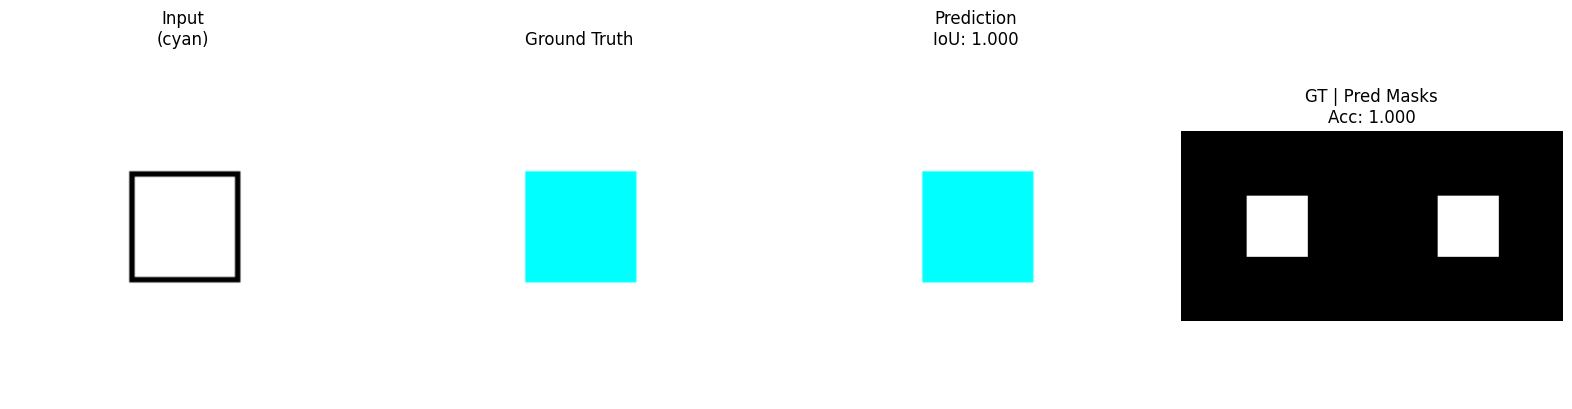

Sample 1: cyan - IoU: 1.000, Accuracy: 1.000


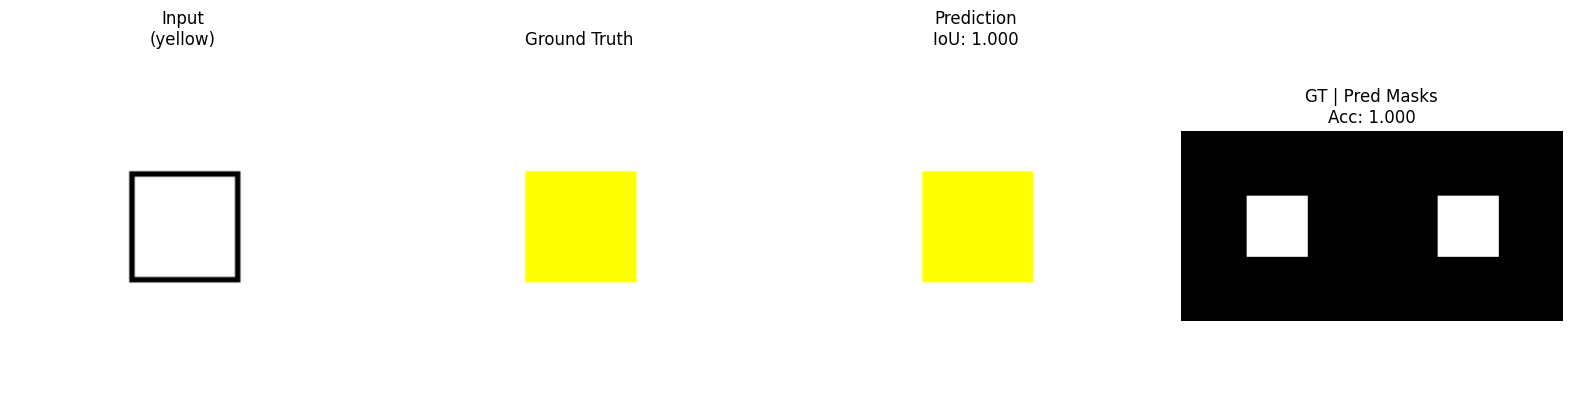

Sample 2: yellow - IoU: 1.000, Accuracy: 1.000


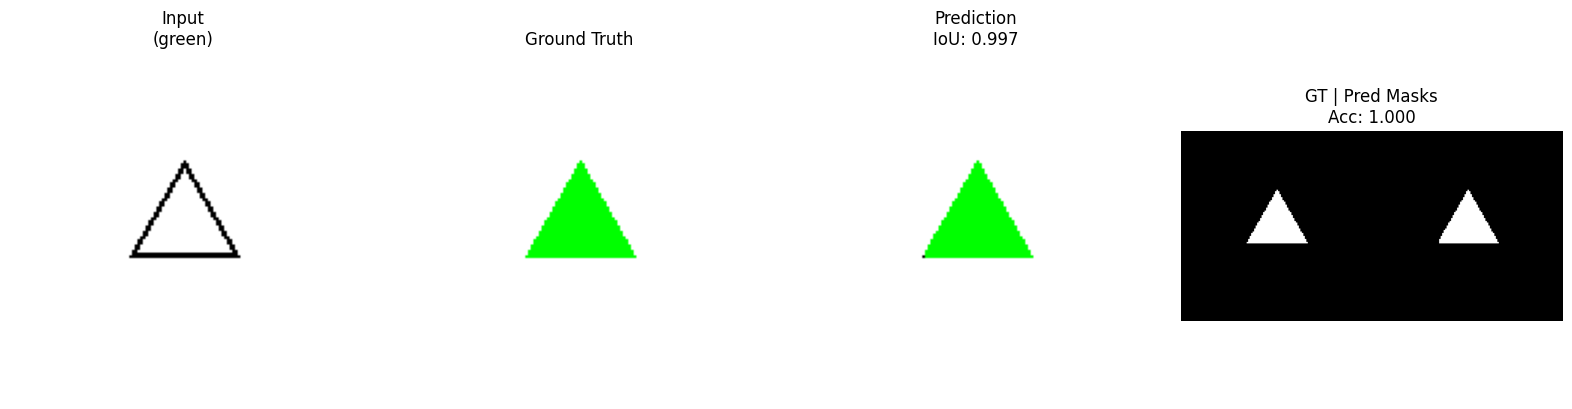

Sample 3: green - IoU: 0.997, Accuracy: 1.000


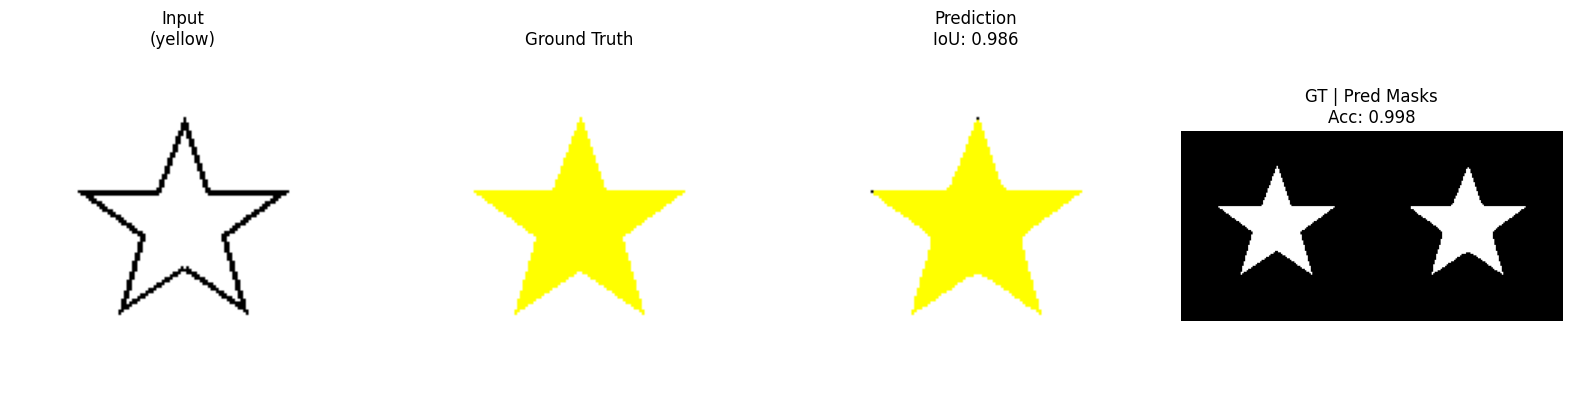

Sample 4: yellow - IoU: 0.986, Accuracy: 0.998


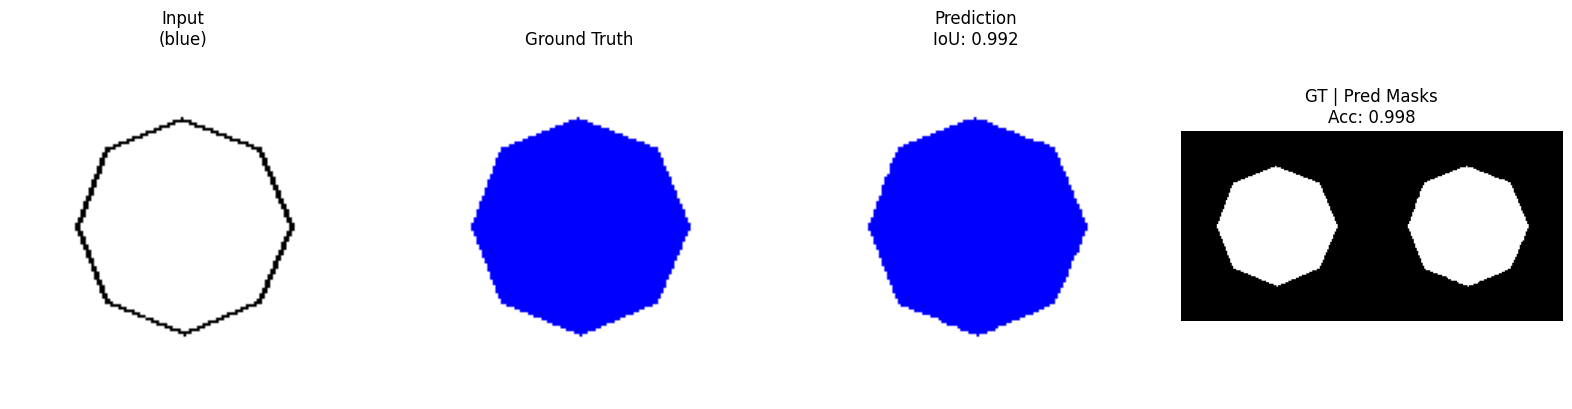

Sample 5: blue - IoU: 0.992, Accuracy: 0.998

🎯 TEST RESULTS SUMMARY
Samples Tested: 8
Average Pixel Accuracy: 0.6245
Average IoU: 0.6218


test/average_iou,▁
test/average_pixel_accuracy,▁
test/average_iou,0.62184
test/average_pixel_accuracy,0.62447


In [15]:
# Run comprehensive testing
print("🧪 Starting model evaluation...")
avg_acc, avg_iou = simple_test_with_wandb(
    model_path='best_model.pth', 
    split='validation', 
    num_samples=8
)

🔍 Testing: yellow color (sample 0)


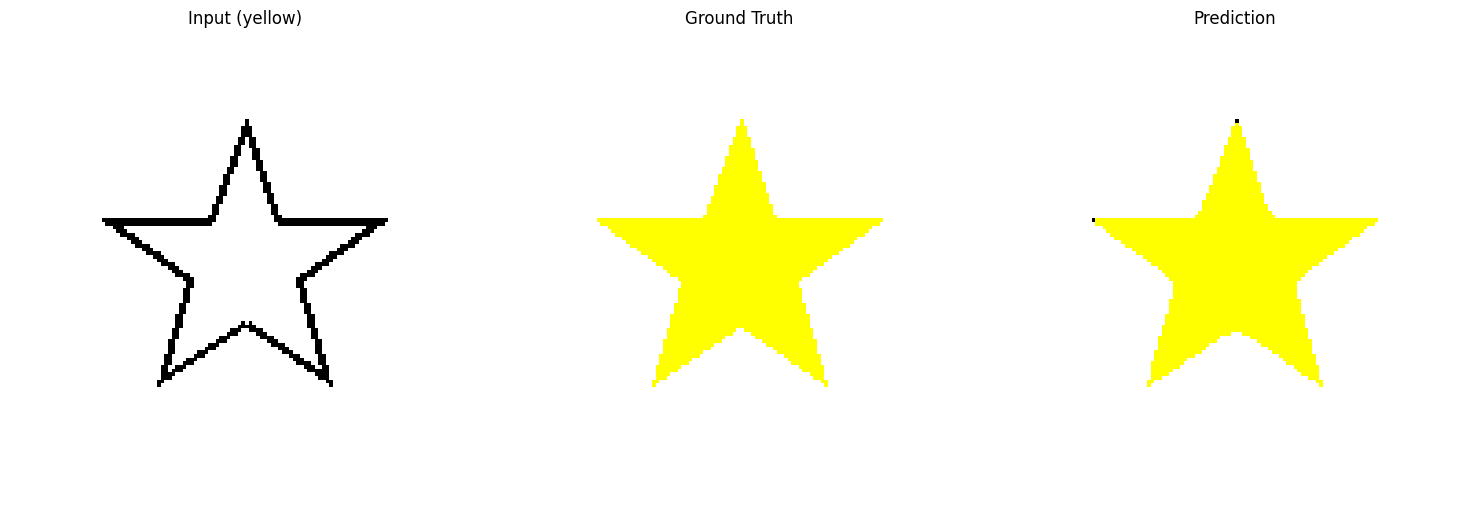

🔍 Testing: green color (sample 1)


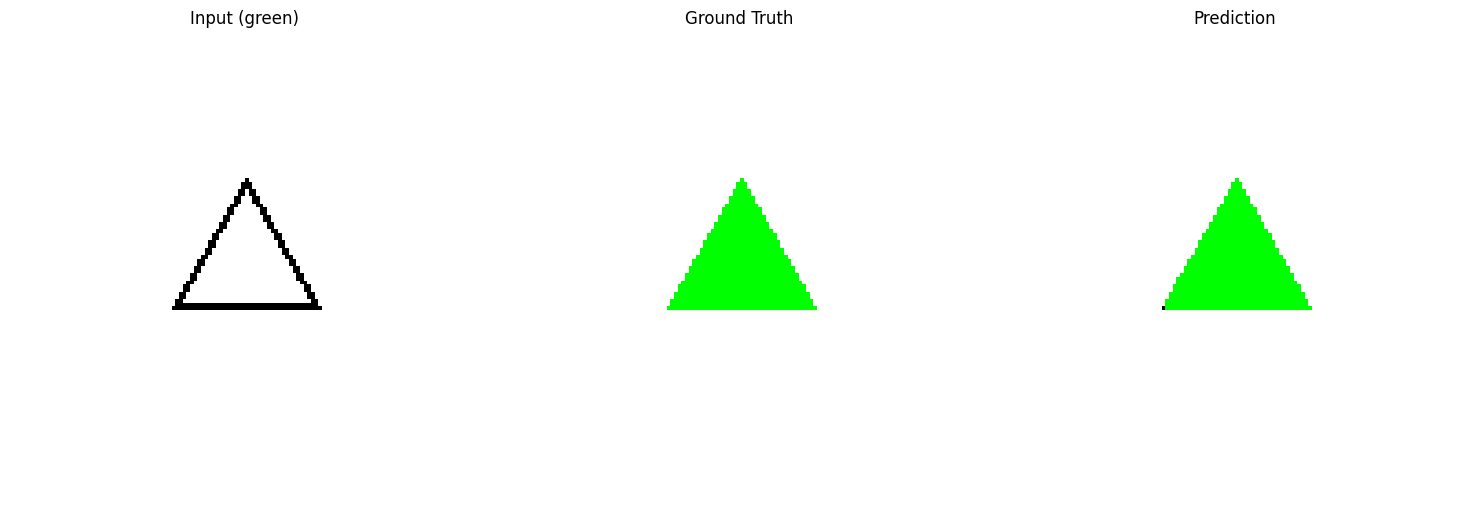

🔍 Testing: blue color (sample 2)


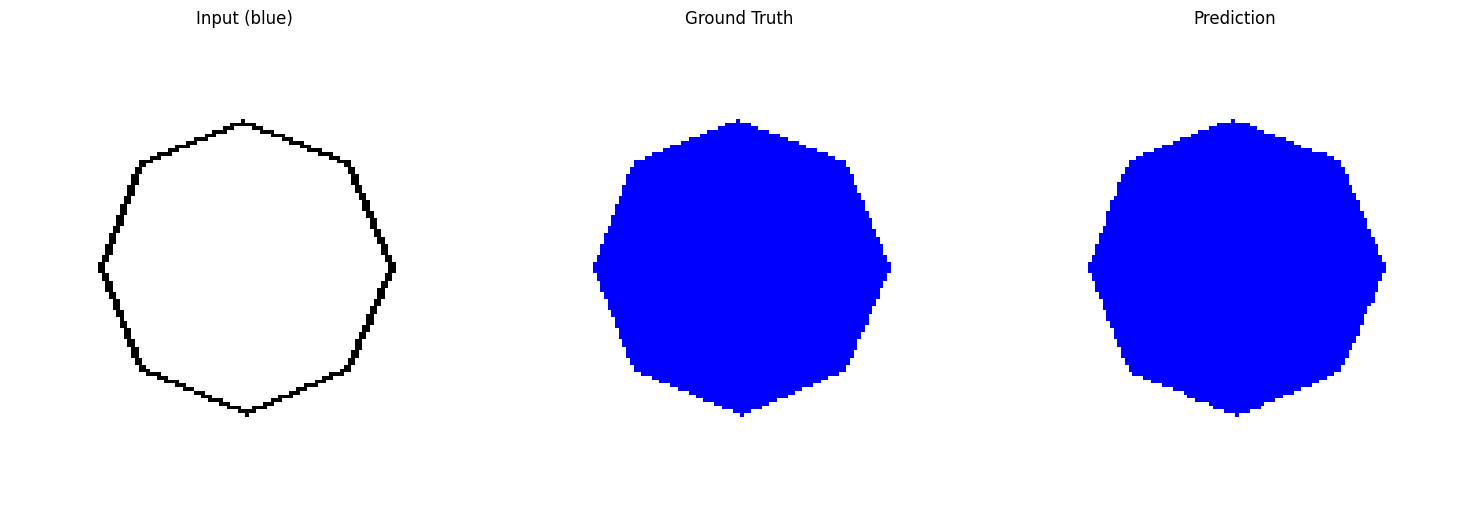

🔍 Testing: yellow color (sample 3)


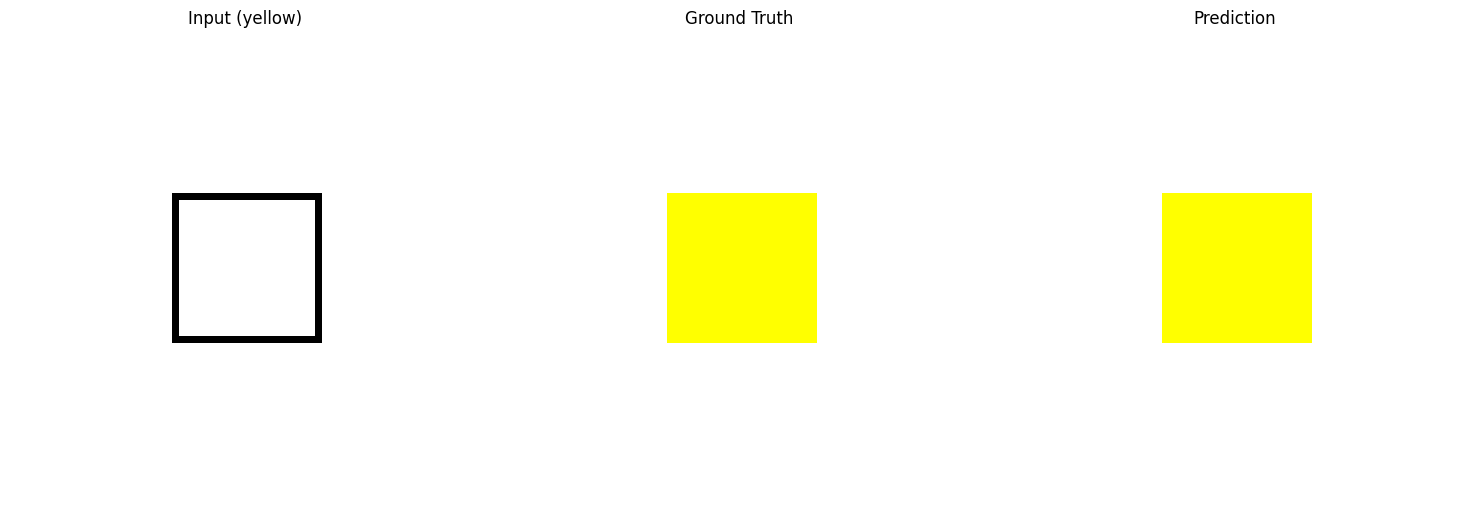

In [26]:
def quick_single_test(sample_idx=0):
    """Quick test on a single image"""
    checkpoint = torch.load('best_model.pth', map_location=DEVICE)
    model = ColorConditionedUNet(checkpoint['num_colors']).to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    color_encoder = checkpoint['color_encoder']
    
    # Load sample
    base = os.path.join(ROOT_DIR, 'validation')
    entries = json.load(open(os.path.join(base, 'data.json')))
    entry = entries[sample_idx]
    
    inp_path = os.path.join(base, 'inputs', entry['input_polygon'])
    out_path = os.path.join(base, 'outputs', entry['output_image'])
    color_name = entry['colour'].lower()
    
    print(f"🔍 Testing: {color_name} color (sample {sample_idx})")
    
    # Process
    input_img = Image.open(inp_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(input_img).unsqueeze(0).to(DEVICE)
    color_idx = torch.tensor([color_encoder[color_name]]).to(DEVICE)
    
    # Predict
    with torch.no_grad():
        logits = model(x, color_idx)[0, 0].cpu()
        pred_mask = torch.sigmoid(logits).numpy()
    
    # Create result
    input_np = np.array(input_img)
    pred_filled = input_np.copy()
    fill_color = COLOR_MAP.get(color_name, [255, 0, 0])
    pred_filled[pred_mask > 0.5] = fill_color
    
    # Display
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(input_img)
    plt.title(f'Input ({color_name})')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    gt_img = Image.open(out_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(gt_img)
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_filled)
    plt.title('Prediction')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test different samples
for i in range(4):
    quick_single_test(i)

In [ ]:
# # ─── TRAINING LOOP ─────────────────────────────────────────────────────────────
# def train_model():
#     ds_train = PolygonColorDataset(ROOT_DIR, 'training')
#     ds_val = PolygonColorDataset(ROOT_DIR, 'validation')
    
#     dl_tr = DataLoader(ds_train, BATCH_SIZE, shuffle=True, num_workers=2)
#     dl_val = DataLoader(ds_val, BATCH_SIZE, shuffle=False, num_workers=2)

#     model = ColorConditionedUNet(ds_train.num_colors).to(DEVICE)
#     opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5)
    
#     # Combined loss: BCE for mask + MSE for spatial consistency
#     bce_loss = nn.BCEWithLogitsLoss()
    
#     best_val = float('inf')

#     for epoch in range(1, EPOCHS+1):
#         # Training
#         model.train()
#         train_loss = 0
#         for x, mask, color_idx, color_rgb in dl_tr:
#             x, mask, color_idx = x.to(DEVICE), mask.to(DEVICE), color_idx.to(DEVICE)
            
#             logits = model(x, color_idx)
#             loss = bce_loss(logits, mask)
            
#             opt.zero_grad()
#             loss.backward()
#             opt.step()
#             train_loss += loss.item()
            
#         train_loss /= len(dl_tr)

#         # Validation
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for x, mask, color_idx, color_rgb in dl_val:
#                 x, mask, color_idx = x.to(DEVICE), mask.to(DEVICE), color_idx.to(DEVICE)
#                 logits = model(x, color_idx)
#                 val_loss += bce_loss(logits, mask).item()
                
#         val_loss /= len(dl_val)
#         scheduler.step(val_loss)

#         print(f"Epoch {epoch}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")
        
#         if val_loss < best_val:
#             best_val = val_loss
#             torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'color_encoder': ds_train.color_encoder,
#                 'num_colors': ds_train.num_colors
#             }, 'color_unet.pth')

#     return model, ds_train.color_encoder

In [ ]:
# # ─── INFERENCE & DISPLAY ────────────────────────────────────────────────────────
# def infer_and_fill(idx=0, split='validation'):
#     # Load model and metadata
#     checkpoint = torch.load('color_unet.pth', map_location=DEVICE)
    
#     model = ColorConditionedUNet(checkpoint['num_colors']).to(DEVICE)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
    
#     color_encoder = checkpoint['color_encoder']
    
#     # Load sample data
#     base = os.path.join(ROOT_DIR, split)
#     entries = json.load(open(os.path.join(base, 'data.json')))
#     e = entries[idx]
    
#     inp_path = os.path.join(base, 'inputs', e['input_polygon'])
#     out_path = os.path.join(base, 'outputs', e['output_image'])
#     color_name = e['colour'].lower()
    
#     # Load and preprocess input
#     img = Image.open(inp_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
#     x = transforms.ToTensor()(img).unsqueeze(0).to(DEVICE)
    
#     color_idx = torch.tensor([color_encoder[color_name]]).to(DEVICE)
    
#     # Get color RGB
#     if color_name in COLOR_MAP:
#         fill_rgb = COLOR_MAP[color_name]
#     else:
#         # Extract from target image
#         tgt_img = Image.open(out_path).convert('RGB')
#         tgt_np = np.array(tgt_img)
#         filled_pixels = tgt_np[tgt_np.mean(axis=2) < 240]
#         fill_rgb = filled_pixels.mean(axis=0).astype(int) if len(filled_pixels) > 0 else [255, 0, 0]

#     # Inference
#     with torch.no_grad():
#         logits = model(x, color_idx)[0, 0].cpu()
#         pred_mask = (torch.sigmoid(logits) > 0.5).numpy()

#     # Create filled image
#     img_np = np.array(img)
#     filled_img = img_np.copy()
#     filled_img[pred_mask] = fill_rgb
    
#     # Load ground truth for comparison
#     gt_img = np.array(Image.open(out_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE)))
#     gt_gray = np.array(Image.open(out_path).convert('L').resize((IMG_SIZE, IMG_SIZE)))
#     gt_mask = gt_gray < 240

#     # Display results
#     fig, axs = plt.subplots(1, 4, figsize=(16, 4))
#     axs[0].imshow(img)
#     axs[0].set_title("Input")
#     axs[0].axis('off')
    
#     axs[1].imshow(gt_mask, cmap='gray')
#     axs[1].set_title("GT Mask")
#     axs[1].axis('off')
    
#     axs[2].imshow(pred_mask, cmap='gray')
#     axs[2].set_title("Pred Mask")
#     axs[2].axis('off')
    
#     axs[3].imshow(filled_img)
#     axs[3].set_title(f"Filled ({color_name})")
#     axs[3].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# # ─── MAIN EXECUTION ─────────────────────────────────────────────────────────────
# if __name__ == '__main__':
#     model, color_encoder = train_model()
#     infer_and_fill(idx=0, split='validation')

In [ ]:
# # simple_test.py

# import os, json, random
# from PIL import Image
# import numpy as np
# import torch
# import torch.nn as nn
# from torchvision import transforms
# import matplotlib.pyplot as plt

# # ─── CONFIGURATION ─────────────────────────────────────────────────────────────
# ROOT_DIR = '/kaggle/input/dataset/dataset'
# IMG_SIZE = 128
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Color mapping
# COLOR_MAP = {
#     'red': [255, 0, 0], 'green': [0, 255, 0], 'blue': [0, 0, 255],
#     'yellow': [255, 255, 0], 'purple': [128, 0, 128], 'orange': [255, 165, 0],
#     'pink': [255, 192, 203], 'cyan': [0, 255, 255], 'brown': [165, 42, 42]
# }

# # ─── SIMPLE ACCURACY CALCULATION ─────────────────────────────────────────────────
# def calculate_accuracy(pred_mask, gt_mask, threshold=0.5):
#     """Calculate basic accuracy metrics"""
#     pred_binary = (pred_mask > threshold).astype(np.uint8)
#     gt_binary = gt_mask.astype(np.uint8)
    
#     # Pixel accuracy
#     pixel_acc = np.mean(pred_binary == gt_binary)
    
#     # IoU calculation
#     intersection = np.sum(pred_binary * gt_binary)
#     union = np.sum(pred_binary) + np.sum(gt_binary) - intersection
#     iou = intersection / (union + 1e-8)
    
#     return pixel_acc, iou

# # ─── SIMPLE MODEL TESTING ─────────────────────────────────────────────────────────
# def simple_test(model_path='color_unet.pth', split='validation', num_samples=6):
#     """Simple testing with visual results"""
    
#     print("Loading model...")
    
#     # Load model
#     checkpoint = torch.load(model_path, map_location=DEVICE)
#     model = ColorConditionedUNet(checkpoint['num_colors']).to(DEVICE)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
    
#     color_encoder = checkpoint['color_encoder']
    
#     # Load test data
#     base = os.path.join(ROOT_DIR, split)
#     entries = json.load(open(os.path.join(base, 'data.json')))
    
#     # Select random samples
#     test_indices = random.sample(range(len(entries)), min(num_samples, len(entries)))
    
#     # Tracking accuracy
#     total_pixel_acc = 0
#     total_iou = 0
    
#     # Create visualization
#     fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
#     if num_samples == 1:
#         axes = axes.reshape(1, -1)
    
#     print(f"Testing on {num_samples} samples...")
    
#     with torch.no_grad():
#         for i, idx in enumerate(test_indices):
#             # Load sample data
#             entry = entries[idx]
#             inp_path = os.path.join(base, 'inputs', entry['input_polygon'])
#             out_path = os.path.join(base, 'outputs', entry['output_image'])
#             color_name = entry['colour'].lower()
            
#             # Load input image
#             input_img = Image.open(inp_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
#             x = transforms.ToTensor()(input_img).unsqueeze(0).to(DEVICE)
            
#             # Get color encoding
#             color_idx = torch.tensor([color_encoder[color_name]]).to(DEVICE)
            
#             # Model prediction
#             logits = model(x, color_idx)[0, 0].cpu()
#             pred_mask = torch.sigmoid(logits).numpy()
            
#             # Load ground truth
#             gt_img = Image.open(out_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
#             gt_gray = np.array(Image.open(out_path).convert('L').resize((IMG_SIZE, IMG_SIZE)))
#             gt_mask = (gt_gray < 240).astype(np.float32)
            
#             # Create prediction image
#             input_np = np.array(input_img)
#             pred_filled = input_np.copy()
            
#             # Get fill color
#             if color_name in COLOR_MAP:
#                 fill_color = COLOR_MAP[color_name]
#             else:
#                 # Extract from ground truth
#                 gt_np = np.array(gt_img)
#                 colored_pixels = gt_np[gt_np.mean(axis=2) < 240]
#                 fill_color = colored_pixels.mean(axis=0).astype(int) if len(colored_pixels) > 0 else [255, 0, 0]
            
#             # Fill the predicted mask
#             pred_filled[pred_mask > 0.5] = fill_color
            
#             # Calculate accuracy
#             pixel_acc, iou = calculate_accuracy(pred_mask, gt_mask)
#             total_pixel_acc += pixel_acc
#             total_iou += iou
            
#             # Display results
#             axes[i, 0].imshow(input_img)
#             axes[i, 0].set_title(f'Input\n({color_name})')
#             axes[i, 0].axis('off')
            
#             axes[i, 1].imshow(gt_img)
#             axes[i, 1].set_title('Ground Truth')
#             axes[i, 1].axis('off')
            
#             axes[i, 2].imshow(pred_filled)
#             axes[i, 2].set_title(f'Prediction\nIoU: {iou:.3f}')
#             axes[i, 2].axis('off')
            
#             # Show masks side by side
#             mask_comparison = np.hstack([gt_mask, pred_mask > 0.5])
#             axes[i, 3].imshow(mask_comparison, cmap='gray')
#             axes[i, 3].set_title(f'GT | Pred Masks\nAcc: {pixel_acc:.3f}')
#             axes[i, 3].axis('off')
            
#             print(f"Sample {i+1}: {color_name} - IoU: {iou:.3f}, Accuracy: {pixel_acc:.3f}")
    
#     # Calculate averages
#     avg_pixel_acc = total_pixel_acc / num_samples
#     avg_iou = total_iou / num_samples
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary
#     print("\n" + "="*50)
#     print(f"TEST RESULTS SUMMARY")
#     print("="*50)
#     print(f"Samples Tested: {num_samples}")
#     print(f"Average Pixel Accuracy: {avg_pixel_acc:.4f}")
#     print(f"Average IoU: {avg_iou:.4f}")
#     print("="*50)
    
#     return avg_pixel_acc, avg_iou

# # ─── SINGLE IMAGE TEST ─────────────────────────────────────────────────────────────
# def test_single_image(model_path='color_unet.pth', sample_idx=0, split='validation'):
#     """Test on a single image with detailed view"""
    
#     # Load model
#     checkpoint = torch.load(model_path, map_location=DEVICE)
#     model = ColorConditionedUNet(checkpoint['num_colors']).to(DEVICE)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
    
#     color_encoder = checkpoint['color_encoder']
    
#     # Load sample
#     base = os.path.join(ROOT_DIR, split)
#     entries = json.load(open(os.path.join(base, 'data.json')))
#     entry = entries[sample_idx]
    
#     inp_path = os.path.join(base, 'inputs', entry['input_polygon'])
#     out_path = os.path.join(base, 'outputs', entry['output_image'])
#     color_name = entry['colour'].lower()
    
#     print(f"Testing sample {sample_idx}: {color_name} color")
    
#     # Load and process
#     input_img = Image.open(inp_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
#     x = transforms.ToTensor()(input_img).unsqueeze(0).to(DEVICE)
#     color_idx = torch.tensor([color_encoder[color_name]]).to(DEVICE)
    
#     # Predict
#     with torch.no_grad():
#         logits = model(x, color_idx)[0, 0].cpu()
#         pred_mask = torch.sigmoid(logits).numpy()
    
#     # Load ground truth
#     gt_img = Image.open(out_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
#     gt_gray = np.array(Image.open(out_path).convert('L').resize((IMG_SIZE, IMG_SIZE)))
#     gt_mask = (gt_gray < 240).astype(np.float32)
    
#     # Create prediction
#     input_np = np.array(input_img)
#     pred_filled = input_np.copy()
#     fill_color = COLOR_MAP.get(color_name, [255, 0, 0])
#     pred_filled[pred_mask > 0.5] = fill_color
    
#     # Calculate metrics
#     pixel_acc, iou = calculate_accuracy(pred_mask, gt_mask)
    
#     # Display
#     plt.figure(figsize=(15, 5))
    
#     plt.subplot(1, 3, 1)
#     plt.imshow(input_img)
#     plt.title(f'Input ({color_name})')
#     plt.axis('off')
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(gt_img)
#     plt.title('Ground Truth')
#     plt.axis('off')
    
#     plt.subplot(1, 3, 3)
#     plt.imshow(pred_filled)
#     plt.title(f'Prediction\nIoU: {iou:.3f}, Acc: {pixel_acc:.3f}')
#     plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()
    
#     print(f"Results: IoU = {iou:.4f}, Pixel Accuracy = {pixel_acc:.4f}")
    
#     return pixel_acc, iou

# # ─── MAIN TESTING ─────────────────────────────────────────────────────────────────
# if __name__ == '__main__':
#     # Make sure to import the ColorConditionedUNet class from your main training code
    
#     print("🎯 Simple Model Testing")
#     print("="*30)
    
#     # Test multiple samples
#     avg_acc, avg_iou = simple_test(
#         model_path='color_unet.pth', 
#         split='validation', 
#         num_samples=6
#     )
    
#     print("\n" + "🔍 Single Image Detailed Test")
#     print("="*30)
    
#     # Test single image
#     test_single_image(
#         model_path='color_unet.pth', 
#         sample_idx=0, 
#         split='validation'
#     )